# Brainles Preprocessing Tutorial
In this Notebook, we will demonstrate how to preprocess brain MR images with the [BrainLes preprocessing package](https://github.com/BrainLesion/preprocessing/tree/main/brainles_preprocessing).
<!-- TODO elaborate -->




## Why Preprocessing?
Many downstream tasks will require some sort of preprocessing of data:
- Segmentation algorithms (e.g. BraTS challenge algorithms expect co-registered, skull-stripped files in SRI-24 space)
- Making data public requires anonymization (e.g. achievable by performing brain extraction or defacing)

Our [BrainLes preprocessing package](https://github.com/BrainLesion/preprocessing/tree/main/brainles_preprocessing) allows to perform preprocessing in modular and backend agnostic way, meaning different registration, brain extraction and defacing tools can be used.


## Requirements
This tutorial requires:

* Python 3.10+ environment
* Docker
* Linux (Windows and Mac OS will be supported in future versions)
<!-- TODO specify version -->

optional (but recommended):
* CUDA
<!-- TODO specify -->


## Setup Colab environment
If you installed the packages and requirements on your own machine, you can skip this section and start from the import section. Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a target="_blank" href="https://colab.research.google.com/github/BrainLesion/tutorials/blob/main/preprocessing/preprocessing_tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Now that you are visualizing the notebook in Colab, run the next cell to install the packages we will use. There are a few things you should follow in order to properly set the notebook up:
1. Warning: This notebook was not authored by Google. Click on 'Run anyway'.
1. When the installation commands are done, there might be "Restart runtime" button at the end of the output. Please, click it.


By running the next cell you are going to create a folder in your Google Drive. All the files for this tutorial will be uploaded to this folder. After the first execution you might receive some warning and notification, please follow these instructions:
1. Permit this notebook to access your Google Drive files? Click on 'Yes', and select your account.
Google Drive for desktop wants to access your Google Account. Click on 'Allow'.
1. At this point, a folder has been created and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive

In [ ]:
# Create a folder in your Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Don't run this cell if you already cloned the repo
# !git clone https://github.com/BrainLesion/tutorials.git

In [2]:
# make files from the repo available in colab
import sys
from pathlib import Path

COLAB_BASE_PATH = Path("/content/tutorials/preprocessing/")
sys.path.insert(0, COLAB_BASE_PATH)

# Usage

## Installation of dependencies and imports

In [ ]:
%pip install brainles_preprocessing matplotlib > /dev/null

%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path

from brainles_preprocessing.defacing import QuickshearDefacer
from brainles_preprocessing.brain_extraction import HDBetExtractor
from brainles_preprocessing.modality import Modality, CenterModality
from brainles_preprocessing.preprocessor import Preprocessor
from brainles_preprocessing.registration import ANTsRegistrator
from brainles_preprocessing.normalization.percentile_normalizer import (
    PercentileNormalizer,
)

import utils

/home/marcelrosier/preprocessing/brainles_preprocessing/registration/__init__.py:13: UserWarning:

eReg package not found. If you want to use it, please install it using 'pip install brainles_preprocessing[ereg]'



## Specify input and output paths

In [3]:
# specify input and output paths
data_folder = Path("data/TCGA-DU-7294")

t1c_file = data_folder / "t1c.nii.gz"
t1_file = data_folder / "t1.nii.gz"
fla_file = data_folder / "fla.nii.gz"
t2_file = data_folder / "t2.nii.gz"

output_dir = Path("output")
t1c_normalized_skull_output_path = output_dir / "t1c_normalized_skull.nii.gz"
t1c_normalized_bet_output_path = output_dir / "t1c_normalized_bet.nii.gz"
t1c_normalized_defaced_output_path = output_dir / "t1c_normalized_defaced.nii.gz"
t1c_bet_mask = output_dir / "t1c_bet_mask.nii.gz"
t1c_defacing_mask = output_dir / "t1c_defacing_mask.nii.gz"

t1_normalized_bet_output_path = output_dir / "t1_normalized_bet.nii.gz"
fla_normalized_bet_output_path = output_dir / "fla_normalized_bet.nii.gz"
t2_normalized_bet_output_path = output_dir / "t2_normalized_bet.nii.gz"

## Inspect input data
Let's take a look at our input data to understand what we are working with (Note the differing resolutions)

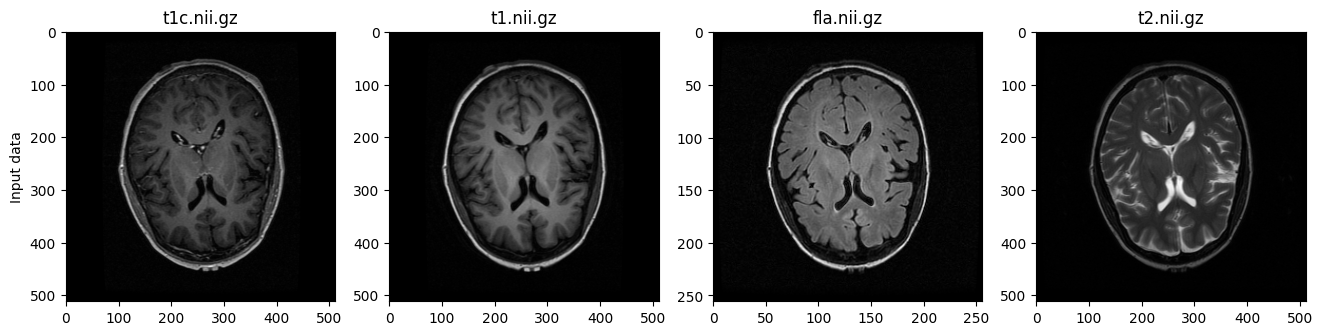

In [18]:
utils.visualize_data(files=[t1c_file, t1_file, fla_file, t2_file], label="Input data")

## Preprocessor Setup

Setup the Preprocessor by defining:
- (Optional) normalizer
- Center modality (center for co-registration) with desired outputs
- Moving modalities with desired outputs

In [11]:
# normalizer
percentile_normalizer = PercentileNormalizer(
    lower_percentile=0.1,
    upper_percentile=99.9,
    lower_limit=0,
    upper_limit=1,
)
# define modalities


# Define the center modality, i.e. the modality to which all other modalities are co-registered has its own class
# to allow saving saving additional that are only relevant for the center modality (brain extraction (bet) and defacing masks)

center = CenterModality(
    modality_name="t1c",
    input_path=t1c_file,
    normalizer=percentile_normalizer,
    # specify desired outputs, here we want to save the normalized skull, bet and defaced images
    normalized_skull_output_path=t1c_normalized_skull_output_path,
    normalized_bet_output_path=t1c_normalized_bet_output_path,
    normalized_defaced_output_path=t1c_normalized_defaced_output_path,
    # also save the bet and defacing mask
    bet_mask_output_path=t1c_bet_mask,
    defacing_mask_output_path=t1c_defacing_mask,
)


# Define the moving modalities, i.e. the modalities that are co-registered to the center modality.
# They mostly have the same structure as the center modality, but do not have some additional output (brain extraction (bet) and defacing masks)
moving_modalities = [
    Modality(
        modality_name="t1",
        input_path=t1_file,
        normalizer=percentile_normalizer,
        normalized_bet_output_path=t1_normalized_bet_output_path,
    ),
    Modality(
        modality_name="t2",
        input_path=t2_file,
        normalizer=percentile_normalizer,
        normalized_bet_output_path=t2_normalized_bet_output_path,
    ),
    Modality(
        modality_name="flair",
        input_path=fla_file,
        normalizer=percentile_normalizer,
        normalized_bet_output_path=fla_normalized_bet_output_path,
    ),
]
preprocessor = Preprocessor(
    center_modality=center,
    moving_modalities=moving_modalities,
    # Use ANTs for registration, other options are Niftyreg or eReg
    registrator=ANTsRegistrator(),
    # Use HDBet for brain extraction
    brain_extractor=HDBetExtractor(),
    # Use Quickshear for defacing,
    defacer=QuickshearDefacer(),
    # limit cuda devices to the gpu you want to use. CPU computation is also possible but slow
    limit_cuda_visible_devices="0",
)

## Run pipeline

In [12]:
# the first run can be slower since the model weights for brain extraction are downloaded
preprocessor.run()

[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:52:24+0100: ============================ Starting preprocessing ============================
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:52:24+0100: Logs are saved to /home/marcelrosier/tutorials/preprocessing/brainles_preprocessing_2024-11-07_T10-52-24.996942.log
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:52:24+0100: Received center modality: t1c and moving modalities: t1, t2, flair
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:52:24+0100: --------------------------- Starting Coregistration ----------------------------
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:52:24+0100: Coregistering 3 moving modalities to center modality...


[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:52:24+0100: Registering modality t1 (file=co__t1c__t1) to center modality...
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:52:36+0100: Registering modality t2 (file=co__t1c__t2) to center modality...
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:52:49+0100: Registering modality flair (file=co__t1c__flair) to center modality...
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:00+0100: Coregistration complete. Output saved to None
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:00+0100: ------------------------- Starting atlas registration --------------------------
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:00+0100: Registering center modality to atlas...
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:07+0100: Atlas registration complete. Output saved to /tmp/tmpy95ak7_t/atlas-space
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53

File: /tmp/tmpy95ak7_t/atlas-space/atlas__t1c.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...


[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:41+0100: Applying brain mask to t1...
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:42+0100: Applying brain mask to t2...
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:42+0100: Applying brain mask to flair...
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:43+0100: Saving brain extracted (bet), i.e. skull-stripped images...
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:44+0100: -------------------------- Checking optional defacing --------------------------
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:44+0100: Starting defacing...
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:44+0100: Defacing center modality...
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:45+0100: Applying deface mask to t1c...
[INFO | brainles_preprocessing.preprocessor] 2024-11-07T10:53:45+0100: Applying deface mask to t1...
[INFO | brainles_pre

## Inspect the outputs

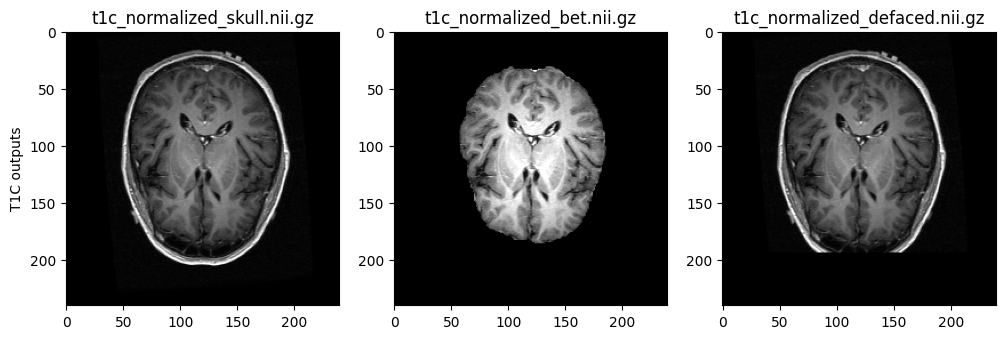

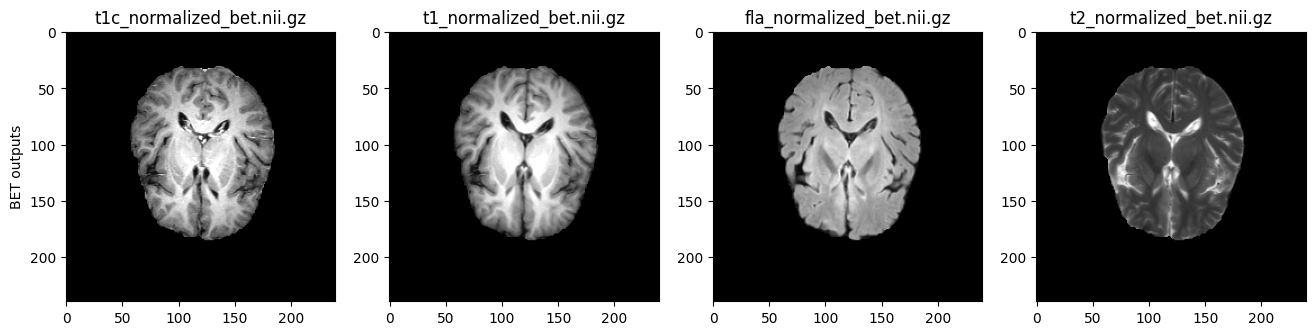

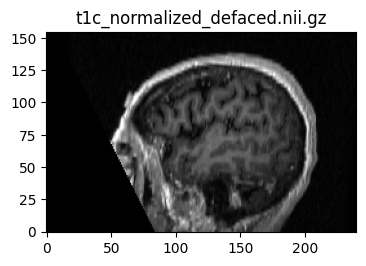

In [52]:
# inspect the different outputs for the center modality (normalized atlas registered with skull, brain extracted (bet) and defaced)
utils.visualize_data(
    files=[
        t1c_normalized_skull_output_path,
        t1c_normalized_bet_output_path,
        t1c_normalized_defaced_output_path,
    ],
    label="T1C outputs",
)

# inspect the different outputs for the all modalities (normalized atlas registered brain extracted (bet))
utils.visualize_data(
    files=[
        t1c_normalized_bet_output_path,
        t1_normalized_bet_output_path,
        fla_normalized_bet_output_path,
        t2_normalized_bet_output_path,
    ],
    label="BET outputs",
)

# showcase the defacing result from a more suitable angle
utils.visualize_defacing(file=t1c_normalized_defaced_output_path)